In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical
from torch.autograd import Variable
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Environment 1:Cartpole

In [2]:
env=gym.make('CartPole-v1')


In [3]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.dense1 = nn.Linear(len(env.observation_space.sample()), 128)
    self.relu=nn.ReLU()
    self.dense2 = nn.Linear(128, 256)
    self.dense3 = nn.Linear(256, env.action_space.n)
    self.softmax= nn.Softmax(-1)

  def forward(self,x):
    x=self.dense1(x)
    x=self.relu(x)
    x=self.dense2(x)
    x=self.relu(x)
    x=self.dense3(x)
    x=self.softmax(x)
    # print(x)
    x=Categorical(x)
    return x


class Critic(nn.Module):
    def __init__(self,):
      super(Critic, self).__init__()
      self.dense1 = nn.Linear(len(env.observation_space.sample())+env.action_space.n, 128)
      self.relu=nn.ReLU()
      self.dense2 = nn.Linear(128, 256)
      self.dense3 = nn.Linear(256, 1)

    def forward(self, x):
      x=self.dense1(x)
      x=self.relu(x)
      x=self.dense2(x)
      x=self.relu(x)
      x=self.dense3(x)
      return x

def get_OneHot_Actions(actions,number_of_actions):
  t=torch.zeros(number_of_actions)
  t[action]=1
  # print(t)
  return t



actor=Actor().to(device)
critic=Critic().to(device)
number_of_episodes=2000
Actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
Critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
gamma=0.99
rew_per_episode=[]
avg_rewards_per_episodes=[]
for episode in range(1, number_of_episodes+1):
  current_state= env.reset()
  state= torch.FloatTensor(current_state).to(device)
  done=False
  cum_rew=0
  log_prob_list = []
  value_list = []
  reward_list = []
  done_list = []
  returns=[]

  while done==False:
    actions=actor(state)
    action=actions.sample()
    encoded_actions=get_OneHot_Actions(action, env.action_space.n)
    value=critic(torch.cat((state,encoded_actions)))
    # print(actions,value)
    # print(action)
    log_prob=actions.log_prob(action).unsqueeze(0)
    # print(log_prob)
    # print(action,value)
    next_state, reward, done, _ = env.step(np.asarray(action))
    cum_rew+=reward
    next_state=torch.Tensor(next_state).to(device)    
    reward=torch.Tensor([reward]).to(device)
    if done:
      done_list.append(torch.Tensor([0]).to(device))
    else:
      done_list.append(torch.Tensor([1]).to(device)) 
    # log_prob=torch.tensor([log_prob]).to(device)
    log_prob_list.append(log_prob)
    value_list.append(value)
    reward_list.append(reward)
    state=next_state
  value_list=torch.cat(value_list).to(device)
  # print(log_prob_list)
  log_prob_list=torch.cat(log_prob_list).to(device)
  # print(value_list)
  R=critic(torch.cat((state,encoded_actions)))
  # print(log_prob_list)
  # print(R)
  # print(reward_list)
  returns=[]
  for i in range(len(reward_list)-1, -1,-1):
    # print(done_list[i], reward_list[i])
    R=reward_list[i]+gamma*R*done_list[i]
    returns.insert(0,R)
  # print(returns)
  returns=torch.cat(returns).to(device)
  # print(returns)
  advantage=returns-value_list
  # print("A",advantage)
  # print("L",log_prob_list)
  td_error=(-log_prob_list*advantage).mean()
  value_error=advantage.mean()
  # print("saKXML",value_error)
  # print("AL:",td_error)
  # print("CL:", value_error)
  Actor_optimizer.zero_grad()
  Critic_optimizer.zero_grad()
  (td_error).backward(retain_graph=True)
  Actor_optimizer.step()
  value_error.backward()
  Critic_optimizer.step()
    # print(log_prob)
    # print(done_list)
    # break
  rew_per_episode.append(cum_rew)
  # print('--------Episode:',episode,'--------Reward:',cum_rew)

  if len(rew_per_episode)>20:
    s=sum(rew_per_episode[len(rew_per_episode)-20:len(rew_per_episode)])/20
    print('--------Episode:',episode,'--------Reward:',cum_rew,'-------Avg Rewards(last 20 episodes):', int(s))
    avg_rewards_per_episodes.append(s)
    if s>470:
      print("Converged!")
      break
  else:
    # print(len(avg_rewards_per_episodes))
    avg_rewards_per_episodes.append(int(sum(avg_rewards_per_episodes)/(len(avg_rewards_per_episodes)+1)))


--------Episode: 21 --------Reward: 21.0 -------Avg Rewards(last 20 episodes): 17
--------Episode: 22 --------Reward: 10.0 -------Avg Rewards(last 20 episodes): 15
--------Episode: 23 --------Reward: 14.0 -------Avg Rewards(last 20 episodes): 15
--------Episode: 24 --------Reward: 26.0 -------Avg Rewards(last 20 episodes): 16
--------Episode: 25 --------Reward: 16.0 -------Avg Rewards(last 20 episodes): 16
--------Episode: 26 --------Reward: 10.0 -------Avg Rewards(last 20 episodes): 16
--------Episode: 27 --------Reward: 18.0 -------Avg Rewards(last 20 episodes): 16
--------Episode: 28 --------Reward: 20.0 -------Avg Rewards(last 20 episodes): 16
--------Episode: 29 --------Reward: 22.0 -------Avg Rewards(last 20 episodes): 17
--------Episode: 30 --------Reward: 11.0 -------Avg Rewards(last 20 episodes): 17
--------Episode: 31 --------Reward: 21.0 -------Avg Rewards(last 20 episodes): 17
--------Episode: 32 --------Reward: 10.0 -------Avg Rewards(last 20 episodes): 17
--------Episode:

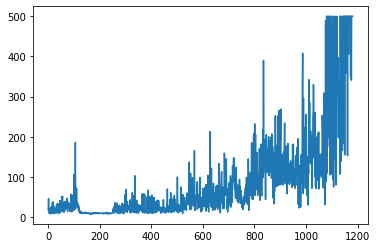

In [4]:
plt.plot(rew_per_episode)

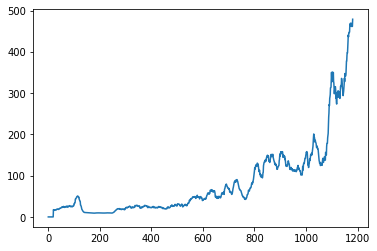

In [5]:
plt.plot(avg_rewards_per_episodes)

In [8]:
print("-----------Evaluation-------------")
tot=[]
for i in range(0,10):
  state= env.reset()
  state= torch.FloatTensor(current_state).to(device)
  done=False
  cum_rew=0
  
  while done==False:
    actions=actor.forward(state)
    action=actions.sample().item()
    # print(action)
    next_state, reward, done, _ = env.step(action)
    cum_rew+=reward
    state=torch.Tensor(next_state).to(device)
  tot.append(cum_rew)
  print('Episode ',i,':',cum_rew)

print("Average:", sum(tot)/10)

-----------Evaluation-------------
Episode  0 : 500.0
Episode  1 : 500.0
Episode  2 : 500.0
Episode  3 : 500.0
Episode  4 : 446.0
Episode  5 : 500.0
Episode  6 : 500.0
Episode  7 : 500.0
Episode  8 : 500.0
Episode  9 : 500.0
Average: 494.6


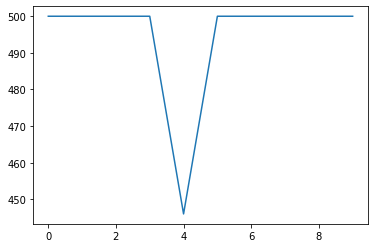

In [9]:
plt.plot(tot)

###Environment 2: LUNAR LANDER

In [8]:
!pip3 install box2d-py
!pip install gym[box2d]

     |████████████████████████████████| 448 kB 34.3 MB/s 


In [9]:
env = gym.make("LunarLander-v2")
env.observation_space.sample()

array([-2.4591038 , -1.4711062 , -0.9761585 , -1.9652203 , -0.32201684,
        0.64566684,  0.9901996 , -0.6937806 ], dtype=float32)

In [10]:
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.dense1 = nn.Linear(len(env.observation_space.sample()), 128)
    self.relu=nn.ReLU()
    self.dense2 = nn.Linear(128, 256)
    self.dense3 = nn.Linear(256, env.action_space.n)
    self.softmax= nn.Softmax(-1)

  def forward(self,x):
    x=self.dense1(x)
    x=self.relu(x)
    x=self.dense2(x)
    x=self.relu(x)
    x=self.dense3(x)
    x=self.softmax(x)
    # print(x)
    x=Categorical(x)
    return x


class Critic(nn.Module):
    def __init__(self,):
      super(Critic, self).__init__()
      self.dense1 = nn.Linear(len(env.observation_space.sample()), 128)
      self.relu=nn.ReLU()
      self.dense2 = nn.Linear(128, 256)
      self.dense3 = nn.Linear(256, 1)

    def forward(self, x):
      x=self.dense1(x)
      x=self.relu(x)
      x=self.dense2(x)
      x=self.relu(x)
      x=self.dense3(x)
      return x

actor=Actor()
critic=Critic()
number_of_episodes=1300
Actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
Critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)
gamma=0.99
rew_per_episode=[]

for episode in range(1, number_of_episodes+1):
  current_state= env.reset()
  state= torch.FloatTensor(current_state)
  done=False
  cum_rew=0
  log_prob_list = []
  value_list = []
  reward_list = []
  done_list = []
  returns=[]
  #entropy = 0

  while done==False:
    state= torch.FloatTensor(state)
    actions=actor(state)
    action=actions.sample()
    value=critic(state)
    next_state, reward, done, _ = env.step(action.numpy())
    log_prob = actions.log_prob(action).unsqueeze(0)
    #entropy += actions.entropy().mean()
    cum_rew+=reward
    if done:
      done_list.append(torch.Tensor([0]))
    else:
      done_list.append(torch.Tensor([1])) 
    reward=torch.Tensor([reward])
    log_prob_list.append(log_prob)
    value_list.append(value)
    reward_list.append(reward)
    state = next_state

  next_state = torch.FloatTensor(next_state)
  R = critic(next_state)
  returns=[]
  for i in range(len(reward_list)-1, -1,-1):
    R=reward_list[i]+gamma*R*done_list[i]
    returns.insert(0,R)

  rew_per_episode.append(cum_rew)
  log_prob_list=torch.cat(log_prob_list).to(device)
  returns = torch.cat(returns).detach()
  #print(returns)
  value_list = torch.cat(value_list)

  advantage = returns - value_list
  actor_loss = -(log_prob_list * advantage.detach()).mean()
  critic_loss = advantage.pow(2).mean()
  Actor_optimizer.zero_grad()
  Critic_optimizer.zero_grad()
  actor_loss.backward(retain_graph=True)
  critic_loss.backward()
  Actor_optimizer.step()
  Critic_optimizer.step()
  print('--------Episode:',episode,'--------Reward:',cum_rew)


--------Episode: 1 --------Reward: -102.19307527958988
--------Episode: 2 --------Reward: -52.74989341331829
--------Episode: 3 --------Reward: -76.45135469515222
--------Episode: 4 --------Reward: -185.33022570993992
--------Episode: 5 --------Reward: 29.464206224960066
--------Episode: 6 --------Reward: -167.234223308764
--------Episode: 7 --------Reward: -120.45260130507799
--------Episode: 8 --------Reward: -93.1788173994405
--------Episode: 9 --------Reward: -119.68552180864444
--------Episode: 10 --------Reward: -184.66251972768205
--------Episode: 11 --------Reward: -130.5061550736112
--------Episode: 12 --------Reward: -116.61017079453276
--------Episode: 13 --------Reward: -101.68263424617203
--------Episode: 14 --------Reward: -192.11027126966206
--------Episode: 15 --------Reward: -74.46289549580789
--------Episode: 16 --------Reward: -185.88857001875235
--------Episode: 17 --------Reward: -317.08987409798914
--------Episode: 18 --------Reward: -91.56432341591983
--------Epi

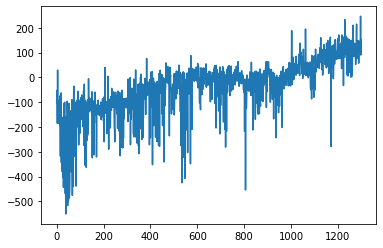

In [11]:
plt.plot(rew_per_episode)

In [14]:
print("-----------Evaluation-------------")
tot=[]
for i in range(0,10):
  state= env.reset()
  state= torch.FloatTensor(current_state).to(device)
  done=False
  cum_rew=0
  
  while done==False:
    actions=actor.forward(state)
    action=actions.sample().item()
    # print(action)
    next_state, reward, done, _ = env.step(action)
    cum_rew+=reward
    state=torch.Tensor(next_state).to(device)
  tot.append(cum_rew)
  print('Episode ',i,':',cum_rew)

print("Average:", sum(tot)/10)


-----------Evaluation-------------
Episode  0 : 130.38310508528664
Episode  1 : 114.87163428151672
Episode  2 : 124.7780202347831
Episode  3 : 209.46486819077467
Episode  4 : 111.51626690731106
Episode  5 : 119.68447665960193
Episode  6 : 65.06006280259594
Episode  7 : 263.40988552302946
Episode  8 : 2.8498572553865813
Episode  9 : -63.998428236950495
Average: 107.80197487033354


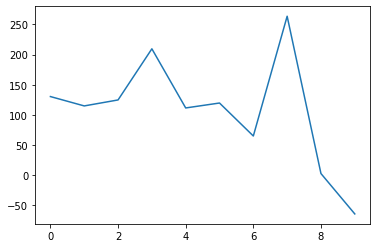

In [15]:
plt.plot(tot)